#### Functions (IGNORE)

In [1]:
# import packages that will be used for analysis
import random
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

##### Collect Stock Data

In [2]:
import yfinance as yf
missing_data_tickers = [] # use this as a list of tickers with missing data

def get_data_from_start_to_end(ticker, start_date, end_date):
    global missing_data_tickers  # Use the global list to accumulate missing tickers
    try:
        stock_data = yf.download(ticker, start=start_date, end=end_date)
        if stock_data.empty:
            missing_data_tickers.append(ticker)
            raise ValueError(f"Stock data for ticker {ticker} during the period from {start_date} to {end_date} was not found.")
        return stock_data
    except Exception as e:
        print(f"An error occurred for ticker {ticker}: {e}")
        missing_data_tickers.append(ticker)
        return None


In [3]:
# for a variety of periods load in different list of tickers
def download_stock_data_for_periods(tickers, periods):
    all_data = {}
    
    for period, (start_date, end_date) in periods.items():
        period_data = {}
        for ticker in tickers:
            data = get_data_from_start_to_end(ticker, start_date, end_date)
            if data is not None:
                period_data[ticker] = data
        all_data[period] = period_data
    
    return all_data

In [4]:
import pandas as pd

# Get the adjusted close prices
adj_close_sector_etf = {}

# Create adjusted close price only listing of sector ETFs
def get_adjusted_closed_price(nested_dict, tickers, periods):
    for period in periods:
        stock_price_df = pd.DataFrame()  # Create a new DataFrame for each period
        for ticker in tickers:
            stock_price_df[ticker] = nested_dict[period][ticker]['Adj Close']
        
        adj_close_sector_etf[period] = stock_price_df  # Store the complete DataFrame for the period
    
    return adj_close_sector_etf

##### Relative Strength Index

In [5]:
def calculate_rsi(data, window):
    """
    Calculate the Relative Strength Index (RSI) for a given stock data series.

    Parameters:
    data (pd.Series): A pandas series of adjusted close prices.
    window (int): The lookback period for RSI calculation, default is 14.

    Returns:
    pd.Series: RSI values.
    """
    delta = data.diff()  # Difference in price from previous price
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()  # Average gain
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()  # Average loss
    
    # Avoid division by zero, especially at the beginning of the dataset
    rs = gain / loss.replace(0, np.nan)  
    
    # RSI formula
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [6]:
# create rsi value in sector etf dataframe

def rsi_value(nested_dict,periods,tickers,window):
    for period in periods:
        for ticker in tickers:
            nested_dict[period][ticker]['RSI'] = calculate_rsi(nested_dict[period][ticker]['Adj Close'],window)

    return nested_dict

In [7]:
import numpy as np

def create_rsi_signal(nested_dict, periods, tickers):
    """
    Adds a 'Signal' column to the nested dictionary based on RSI values.

    Parameters:
    - nested_dict: A nested dictionary where each period contains dataframes for tickers.
                   Each dataframe should have an 'RSI' column.
    - periods: A list of periods to iterate over.
    - tickers: A list of tickers to process within each period.

    Returns:
    - The modified nested dictionary with new 'Signal' columns.
    """
    
    for period in periods:
        for ticker in tickers:
            # Create the 'Signal' column using np.where
            nested_dict[period][ticker]['Signal'] = np.where(
                nested_dict[period][ticker]['RSI'] < 30, 'Buy',
                np.where(nested_dict[period][ticker]['RSI'] > 70, 'Sell', 'Hold')
            )

    return nested_dict

In [8]:
def collect_signals(nested_dict, periods, tickers):
    # Initialize an empty dictionary to hold DataFrames for each period
    rsi_signal_df = {}

    for period in periods:
        # Create a DataFrame for each period with the tickers as columns
        signals_period = pd.DataFrame(columns=tickers)
        
        # Loop through each ticker and extract the 'Signal'
        for ticker in tickers:
            signals_period[ticker] = nested_dict[period][ticker]['Signal']
        
        # Store the DataFrame in the dictionary using the period as the key
        rsi_signal_df[period] = signals_period

    # Return the dictionary containing DataFrames for each period
    return rsi_signal_df

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def plot_with_rsi_signals(rsi_data, title):
    """
    rsi_data: DataFrame that contains 'Adj Close', 'RSI', and 'Signal' columns.
    title: Title for the plot.
    """
    buy_data = []
    sell_data = []

    # Loop through the data to collect buy/sell signals
    for index, row in rsi_data.iterrows():
        if row['Signal'] == 'Buy':
            buy_data.append(row['Adj Close'])
        else:
            buy_data.append(np.nan)

        if row['Signal'] == 'Sell':
            sell_data.append(row['Adj Close'])
        else:
            sell_data.append(np.nan)

    # Create the buy and sell columns
    rsi_data['Buy Data'] = buy_data
    rsi_data['Sell Data'] = sell_data

    # Create the plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    
    # Plot the Adjusted Close Price
    ax1.plot(rsi_data.index, rsi_data['Adj Close'], color='grey', label='Adjusted Close Price')
    ax1.scatter(rsi_data.index, rsi_data['Buy Data'], marker='o', color='green', label='Buy Signal')
    ax1.scatter(rsi_data.index, rsi_data['Sell Data'], marker='o', color='red', label='Sell Signal')
    ax1.set_title(title)
    ax1.set_ylabel('Price')
    ax1.legend(loc='upper left')

    # Plot the RSI
    ax2.plot(rsi_data.index, rsi_data['RSI'], color='blue', label='RSI')
    ax2.axhline(30, color='green', linestyle='--', label='Oversold (30)')
    ax2.axhline(70, color='red', linestyle='--', label='Overbought (70)')
    ax2.set_ylabel('RSI')
    ax2.legend(loc='upper left')

    # Set up x-axis formatting
    plt.xticks(rotation=60)
    plt.xlabel('Date')

    # Display the plot
    plt.tight_layout()
    plt.show()

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to plot percentage-based histogram
def plot_percentage_histogram(data, title, xlabel, ylabel, bins=10, color='skyblue'):
    """
    Plots a percentage-based histogram for the given data.

    Parameters:
    data (array-like): Data to plot the histogram for.
    title (str): Title of the plot.
    xlabel (str): Label for the x-axis.
    ylabel (str): Label for the y-axis.
    bins (int): Number of bins for the histogram.
    color (str): Color for the histogram bars.
    """
    # Set modern aesthetic
    sns.set_style("whitegrid")

    # Create the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=bins, color=color, edgecolor='black',
             weights=np.ones_like(data) / len(data))

    # Convert y-axis to percentages
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y*100:.0f}%'))

    # Add titles and labels with improved font sizes
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)

    # Add gridlines for better readability
    plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

##### Stochastic Modeling

In [11]:
from datetime import timedelta
import numpy as np
import pandas as pd

def zip_calculate_stock_roi(bb_signals_nd, adj_close_nd, periods_date, periods_list, tickers, n_sample, initial_investment, future_investments, percent_to_buy, percent_to_sell):
    # Initialize a nested dictionary to store ROI percentages for each period and ticker
    roi_results = {period: {ticker: [] for ticker in tickers} for period in periods_list}

    # Loop through each economic period
    for period in periods_list:
        # Create the date range for the current period
        date_range = pd.date_range(start=pd.to_datetime(periods_date[period][0]), end=pd.to_datetime(periods_date[period][1]) - timedelta(days=110))
        
        # Get random dates for stochastic modeling
        start_dates = np.random.choice(date_range, size=n_sample, replace=True)

        # Loop through sampled start dates
        for start_date in start_dates:
            time_stamp = pd.to_datetime(start_date)

            # Extract the adjusted close and signal data for time period
            adj_close_period = adj_close_nd[period].loc[time_stamp:time_stamp + timedelta(days=110)]
            bb_signals_period = bb_signals_nd[period].loc[time_stamp:time_stamp + timedelta(days=110)]

            # Initialize variables for each ticker
            account_balance = {ticker: future_investments for ticker in tickers}  # Separate account balance for each stock
            shares_number = {ticker: initial_investment/adj_close_period[ticker].iloc[0] for ticker in tickers}  # Initialize share count for each ticker
            shares_value = {ticker: initial_investment for ticker in tickers}   # Initialize share value for each ticker

            # Iterate over each day in the Bollinger Band signals and adjusted close prices
            for row_idx, (signals_row, adj_close_row) in enumerate(zip(bb_signals_period.iterrows(), adj_close_period.iterrows())):
                signals_row = signals_row[1]  # Extract the actual row (signals) - don't need the index
                adj_close_row = adj_close_row[1]  # Extract the actual row (adjusted close prices)

                # Now zip over the signal row and the corresponding adjusted close price for each ticker
                for ticker, (signal, adj_close_price) in zip(tickers, zip(signals_row, adj_close_row)):
                    
                    # Handle Buy action
                    if signal == 'Buy':
                        amount_to_buy = percent_to_buy * account_balance[ticker]
                        if account_balance[ticker] >= amount_to_buy:
                            shares_to_buy = amount_to_buy / adj_close_price
                            shares_number[ticker] += shares_to_buy
                            account_balance[ticker] -= amount_to_buy

                    # Handle Sell action
                    elif signal == 'Sell':
                        if shares_number[ticker] > 0:
                            shares_value[ticker] = shares_number[ticker] * adj_close_price
                            amount_to_sell = percent_to_sell * shares_value[ticker]
                            if shares_value[ticker] >= amount_to_sell:
                                shares_to_sell = amount_to_sell / adj_close_price
                                shares_number[ticker] -= shares_to_sell
                                account_balance[ticker] += amount_to_sell

            # Calculate total portfolio value for each stock at the end of the period
            for ticker in tickers:
                if shares_number[ticker] > 0:  # Only calculate value if shares are owned
                    portfolio_value = shares_number[ticker] * adj_close_period.iloc[-1][ticker]
                    total_value = account_balance[ticker] + portfolio_value
                    
                    # Calculate profit for this stock
                    profit = total_value - (initial_investment + future_investments)
                    
                    # Calculate ROI based on stock's individual account
                    roi_dollar_value = (profit / (initial_investment + future_investments)) * 100
                else:
                    roi_dollar_value = 0

                # Store ROI in the results dictionary
                roi_results[period][ticker].append(roi_dollar_value)

    return roi_results

In [12]:
def stochastic_roi(tickers,periods,return_rates_list,analysis_type):
    df = pd.DataFrame(index=tickers,columns=periods)
    for period in periods:
        for ticker in tickers:
            data = pd.Series(return_rates_list[period][ticker])
            if analysis_type=='Mean':
                df.at[ticker,period] = data.mean()
            elif analysis_type=='Median':
                df.at[ticker,period] = data.median()
            elif analysis_type=='Std':
                df.at[ticker,period] = data.std()
            elif analysis_type=='Variance':
                df.at[ticker,period] = data.var()

    return df

##### Grid Search

In [13]:

def rsi_length_optimal(etf_data,adj_close_etf_data,periods_date,periods_list,tickers,list_days,n_samples,initial_investment,future_investment,pct_buy,pct_sell):
    # create an empty list which will store the dictionaries of returns
    results = []

    for day in list_days:
        rsi = rsi_value(etf_data,periods_list,tickers,day)

        rsi_signals_data_nd = create_rsi_signal(etf_data,periods_list,tickers)

        rsi_signals = collect_signals(rsi_signals_data_nd,periods_list,tickers)

        rsi_returns = zip_calculate_stock_roi(rsi_signals,adj_close_etf_data,periods_date,periods_list,tickers,n_samples,initial_investment,future_investment,pct_buy,pct_sell)

        rsi_roi = stochastic_roi(tickers,periods_list,rsi_returns,'Mean')

        average_roi = rsi_roi.mean()


        results.append({
        'length':day,
        'trough':average_roi[0],
        'expansion':average_roi[1],
        'peak':average_roi[2],
        'contraction':average_roi[3],
        'all_data':average_roi[4],
    })

        optimized_length = pd.DataFrame(results)

    return optimized_length

# Chapter 3: Relative Strength Index
Relative Strength Index is another popular technique in technical analysis. Similar to bollinger bands it looks to identify when there is an opportunity to enter the market when equities have been overbought or oversold. The RSI is a moving oscillator and falls between a value of 0 and 100. It is typically plotted below the line of an equity to get an overview of the movement of the stock. An asset is overbought when the value is greater than 70 which implies a sell signal and an asset is oversold when the value is less than 30 which implies a buy signal.

## Relative Strength Index Strategy
The goal of the RSI is to create a dataframe of signals based on the thresholds as explained above. This can then be used to analyze the performance of incoprorating RSI signals in comparison to a passive buy and hold strategy. 

Use n days for the time period where you are looking at average gain/average loss. It is typical to use 14 days as recommended by J. Welles Wilder but longer and shorter time periods are also utilized.

Another parameter that can be looked at is the minimum RSI value before a buy/sell signal is created.

#### Methodology

1. Difference the data 
2. Track average gain/loss where gain is the positive movement from day to day and loss is the negative movement
3. Create the RS via the average gain/average loss
4. Create the RSI value by 100 - (100/(1+RS))

## Sector ETF and Time Period Setup

In [14]:
# create time periods for where this takes place
economic_cycle_periods = {

    "trough": ("2008-10-01", "2009-06-01"),
    "expansion": ("2012-01-01", "2015-01-01"),
    "peak": ("2019-06-01", "2020-02-01"),
    "contraction": ("2007-12-01", "2008-10-01"),
    'all_data': ('2005-01-01','2024-06-01')
}

economic_cycle_periods_list = ['trough','expansion','peak','contraction','all_data']

In [15]:
# create etf tickers for sectors
sector_etf_tickers = [
    'XLB', # materials sector
    'XLI', # industrials sector
    'XLF', # financials
    'XLK', # information technology
    'XLY', # consumer discretionary
    'XLP', # consumer staples
    'XLE', # energy
    'XLV', # healthcare
    'VOX', # communication services
    'XLU', # utilities
    'IYR' # real estate
    ]

In [16]:
# save nested dictionary data as a variable to be accessed.
sector_etf_data = download_stock_data_for_periods(sector_etf_tickers,economic_cycle_periods)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [17]:
# adjusted close price dataframe
adj_close_sector_etf = get_adjusted_closed_price(sector_etf_data,sector_etf_tickers,economic_cycle_periods_list)

## Relative Strength Index (RSI)
The first step of incorporating Relative Strength Index into an investment strategy is creating the RSI value. The RSI value is going to be added to the candlestick for the each dataframe. Then understanding that an RSI with value of less than 30 triggers a buy signal and an RSI with a value of greater than 70 signals a sell signal, create a signal column.

In [18]:
# create the rsi values in the nested dictionary this will be between 0 and 100
sector_etf_data = rsi_value(sector_etf_data,economic_cycle_periods_list,sector_etf_tickers,14)

In [19]:
# load in data for Healthcare (XLV) for trough
sector_etf_data['trough']['XLV']

,Open,High,Low,Close,Adj Close,Volume,RSI
Date,,,,,,,
2008-10-01,30.100000,30.480000,30.100000,30.250000,22.927486,6053600,NaN
2008-10-02,30.250000,30.590000,29.930000,30.299999,22.965391,6353400,NaN
2008-10-03,30.600000,30.600000,29.650000,29.650000,22.472727,6814400,NaN
2008-10-06,29.400000,29.879999,27.410000,28.540001,21.631422,8545000,NaN
2008-10-07,28.719999,28.780001,27.389999,27.850000,21.108444,5060200,NaN
...,...,...,...,...,...,...,...
2009-05-22,25.280001,25.400000,25.070000,25.290001,19.404514,3655700,61.398287
2009-05-26,25.190001,25.660000,24.889999,25.520000,19.580990,4412900,60.802744
2009-05-27,25.549999,25.600000,25.219999,25.260000,19.381504,4591100,58.806178


In [20]:
# create rsi signal to buy hold or sell
sector_etf_data = create_rsi_signal(sector_etf_data,economic_cycle_periods_list,sector_etf_tickers)

# show the Healthcare sector during a trough
sector_etf_data['trough']['XLV']

,Open,High,Low,Close,Adj Close,Volume,RSI,Signal
Date,,,,,,,,
2008-10-01,30.100000,30.480000,30.100000,30.250000,22.927486,6053600,NaN,Hold
2008-10-02,30.250000,30.590000,29.930000,30.299999,22.965391,6353400,NaN,Hold
2008-10-03,30.600000,30.600000,29.650000,29.650000,22.472727,6814400,NaN,Hold
2008-10-06,29.400000,29.879999,27.410000,28.540001,21.631422,8545000,NaN,Hold
2008-10-07,28.719999,28.780001,27.389999,27.850000,21.108444,5060200,NaN,Hold
...,...,...,...,...,...,...,...,...
2009-05-22,25.280001,25.400000,25.070000,25.290001,19.404514,3655700,61.398287,Hold
2009-05-26,25.190001,25.660000,24.889999,25.520000,19.580990,4412900,60.802744,Hold
2009-05-27,25.549999,25.600000,25.219999,25.260000,19.381504,4591100,58.806178,Hold


In [21]:
# collect the signals as dataframes based on the period
rsi_signals = collect_signals(sector_etf_data,economic_cycle_periods_list,sector_etf_tickers)

# display the rsi signal for a trough
rsi_signals['trough'].iloc[10:20]

,XLB,XLI,XLF,XLK,XLY,XLP,XLE,XLV,VOX,XLU,IYR
Date,,,,,,,,,,,
2008-10-15,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold
2008-10-16,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold
2008-10-17,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold
2008-10-20,Hold,Hold,Hold,Hold,Buy,Buy,Hold,Hold,Hold,Hold,Buy
2008-10-21,Hold,Hold,Hold,Hold,Buy,Buy,Hold,Hold,Hold,Hold,Buy
2008-10-22,Hold,Hold,Hold,Hold,Buy,Buy,Hold,Hold,Hold,Hold,Buy
2008-10-23,Hold,Hold,Hold,Hold,Buy,Buy,Hold,Hold,Hold,Hold,Buy
2008-10-24,Hold,Hold,Hold,Hold,Buy,Buy,Hold,Hold,Hold,Hold,Buy
2008-10-27,Hold,Hold,Hold,Hold,Hold,Buy,Hold,Hold,Hold,Hold,Buy


### Baseline Model
Looking at the 14 day time period for average returns and average losses, use the signals to stochastically simlate the stock investment

In [22]:
# get the stochastic model
rsi_signal_return = zip_calculate_stock_roi(rsi_signals,adj_close_sector_etf,economic_cycle_periods,economic_cycle_periods_list,sector_etf_tickers,1000,0,100,0.20,0.20)

In [23]:
rsi_return = stochastic_roi(sector_etf_tickers,economic_cycle_periods_list,rsi_signal_return,'Mean')
rsi_return

,trough,expansion,peak,contraction,all_data
XLB,10.618526,1.758855,2.581704,0.179283,1.692369
XLI,2.359148,1.692164,5.426101,-0.870941,1.056884
XLF,6.358592,1.702995,4.280801,-5.27042,1.114222
XLK,9.18932,0.776378,0.816577,-0.843344,1.111273
XLY,7.027781,1.727889,2.550248,1.455178,1.139768
XLP,0.653811,1.536709,0.0,1.720308,1.128231
XLE,7.026189,0.419763,5.053369,0.201021,1.521995
XLV,5.353694,1.62342,1.192964,0.086807,1.245684
VOX,5.840294,1.958048,2.743272,-1.049076,0.889353
XLU,-1.188065,1.327889,1.033818,-0.611243,1.499463


In [24]:
rsi_return.to_csv('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Financial Capstone Project/data/performance_data/rsi/rsi_baseline_model.csv')

In [25]:
rsi_return.mean()

trough         5.835427
expansion      1.408115
peak           2.432053
contraction   -0.164223
all_data       1.213185
dtype: float64

In [26]:
rsi_std = stochastic_roi(sector_etf_tickers,economic_cycle_periods_list,rsi_signal_return,'Std')
rsi_std

,trough,expansion,peak,contraction,all_data
XLB,7.911956,1.866785,1.448256,4.282811,5.062086
XLI,8.229245,2.627801,2.10301,4.137741,4.348594
XLF,20.947847,2.10472,1.78583,8.011118,5.10582
XLK,5.595475,2.003603,0.942832,3.401369,3.839024
XLY,8.058786,1.577962,0.97238,3.661457,3.995639
XLP,4.257761,1.728558,0.0,1.533823,2.031191
XLE,6.952009,4.077268,2.193456,7.301508,7.201367
XLV,3.124571,1.860357,0.598747,3.820448,2.440591
VOX,1.594745,1.805975,1.320586,5.510493,3.871456
XLU,3.329112,1.662008,0.966363,2.418808,3.06747


In [27]:
rsi_std.mean()

trough         7.798737
expansion      2.144786
peak           1.245194
contraction    4.340770
all_data       4.155085
dtype: float64

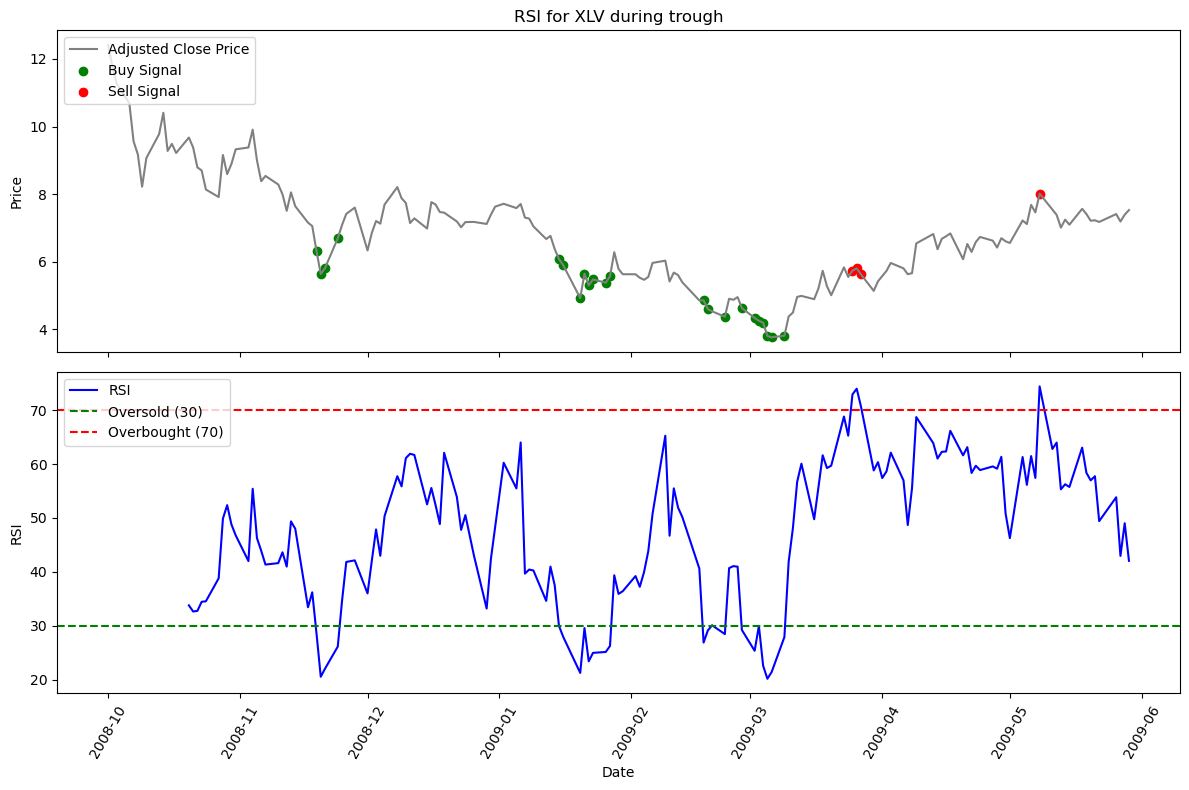

In [28]:
plot_with_rsi_signals(sector_etf_data['trough']['XLF'],'RSI for XLV during trough')

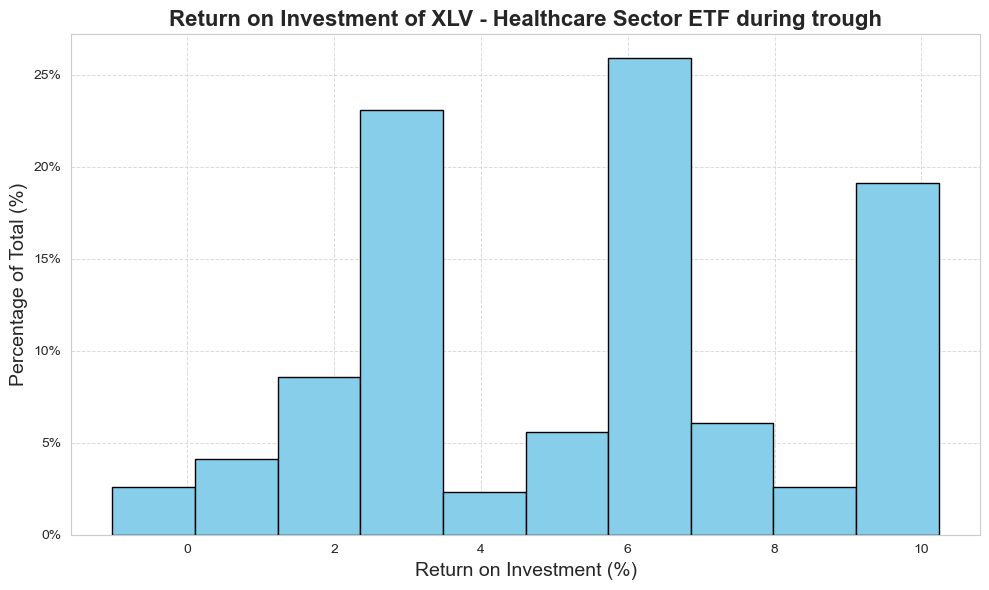

In [29]:
# plot the histogram of the XLV healthcare during a trough
plot_percentage_histogram(
    data=rsi_signal_return['trough']['XLV'],
    title=f'Return on Investment of XLV - Healthcare Sector ETF during trough',
    xlabel='Return on Investment (%)',
        ylabel='Percentage of Total (%)'
)

### Grid Search Optimized Model
The RSI values are made up of looking at a 14 day average return compared to the average loss. Let's do a correlation coefficient to see if the roi based on the length of returns has a strong correlation and should be looked at.

In [38]:
# set the length of periods to investigate
grid_returns = [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]

grid_search_length = rsi_length_optimal(sector_etf_data,adj_close_sector_etf,economic_cycle_periods,economic_cycle_periods_list,sector_etf_tickers,grid_returns,1000,0,100,0.2,0.2)

In [31]:
grid_search_length

,length,trough,expansion,peak,contraction,all_data
0,5,1.371231,2.469601,2.150430,-0.184200,0.622901
1,6,1.447998,1.878780,1.969236,-1.479677,1.412205
2,7,0.511429,2.029168,1.844975,-0.594176,1.528025
3,8,0.749482,1.788705,2.060549,-0.054799,1.014302
4,9,1.083732,1.469346,2.181258,-0.076418,1.876375
5,10,3.292374,1.430785,2.195886,-0.629337,1.585667
6,11,2.775988,1.444582,2.792182,-0.061384,1.182437
7,12,4.341858,1.651677,2.432830,-0.282477,1.016291
8,13,4.553629,1.446257,2.616848,-0.045411,1.739957
9,14,6.184924,1.819922,2.480003,-0.171878,0.961448


In [32]:
# get the highest average return
grid_search_length[['trough','expansion','peak','contraction','all_data']].mean(axis=1)

0     1.285993
1     1.045708
2     1.063884
3     1.111648
4     1.306859
5     1.575075
6     1.626761
7     1.832036
8     2.062256
9     2.254884
10    2.291992
11    2.165574
12    1.967618
13    1.886618
14    1.550262
15    1.234403
16    1.109675
dtype: float64

In [33]:
rsi_optimized_signal_return = zip_calculate_stock_roi(rsi_signals,adj_close_sector_etf,economic_cycle_periods,economic_cycle_periods_list,sector_etf_tickers,1000,0,100,0.25,0.10)

In [34]:
def test_rsi(length):
    etf_rsi_sector_data = rsi_value(sector_etf_data,economic_cycle_periods_list,sector_etf_tickers,length)

    etf_rsi_signal_sector_data = create_rsi_signal(etf_rsi_sector_data,economic_cycle_periods_list,sector_etf_tickers)

    signals = collect_signals(etf_rsi_signal_sector_data,economic_cycle_periods_list,sector_etf_tickers)

    returns = zip_calculate_stock_roi(signals,adj_close_sector_etf,economic_cycle_periods,economic_cycle_periods_list,sector_etf_tickers,1000,0,100,0.25,0.10)

    return returns


In [35]:
optimized_returns = test_rsi(11)

In [36]:
rsi_optimized_signal_return = stochastic_roi(sector_etf_tickers,economic_cycle_periods_list,optimized_returns,'Mean')
rsi_optimized_signal_return

,trough,expansion,peak,contraction,all_data
XLB,11.858919,2.26366,4.321648,-0.155784,2.083586
XLI,-3.923055,2.40744,5.648562,-1.463477,1.598843
XLF,4.426124,1.928556,5.682189,-7.001152,1.284398
XLK,9.863841,1.44836,2.573643,-1.085192,1.893342
XLY,6.785919,1.619661,2.755349,2.026691,1.379194
XLP,-0.335708,2.050394,0.757414,2.052835,1.620029
XLE,5.014892,0.714065,5.057997,-1.187075,1.969237
XLV,2.656724,1.950156,2.373457,-0.21204,1.585625
VOX,8.829661,2.420197,3.771839,-2.111497,1.023477
XLU,-3.551068,1.110617,1.285986,-0.96852,1.43682


In [37]:
rsi_optimized_signal_return.mean()

trough         4.339387
expansion      1.745445
peak           3.334127
contraction   -0.429436
all_data       1.562222
dtype: float64